In [1]:
import os
print(os.cpu_count())
print(os.getcwd())


20
C:\Users\WWWZX\AI_Class_Work\Transformers


In [2]:
import torch
print(torch.__version__)
# print(torch.cuda.is_available())

2.6.0+cu126


In [3]:
import gc
import torch

print(gc.collect())
torch.cuda.empty_cache()


20


In [4]:
# import random
# random.seed(69)

# NumPy random seed
# import numpy as np
# np.random.seed(69)

# PyTorch random seed
# import torch
# torch.manual_seed(69)
# torch.cuda.manual_seed(69)
# torch.cuda.manual_seed_all(69)  # If using multi-GPU
torch.cuda.empty_cache()
torch.backends.cudnn.deterministic = False  # For deterministic results
torch.backends.cudnn.benchmark = True  # Disabling to ensure deterministic algorithm
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')  # Optimize matmul precision

In [5]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Torch CUDA Version:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA Available: True
CUDA Version: 12.6
Torch CUDA Version: NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
import torch

# Check if CUDA is available
gpu_available = torch.cuda.is_available()
print("CUDA Available:", gpu_available)

if gpu_available:
    # Get the number of GPUs available
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)

CUDA Available: True
Number of GPUs available: 1


In [7]:
from pathlib import Path
import random
import gc
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint,RichProgressBar,TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from lightning.pytorch.tuner.tuning import Tuner
torch.serialization.add_safe_globals([TimeSeriesDataSet, GroupNormalizer])

In [8]:
file_path = "further_processed_sales_data_optimized_dtypes.parquet"
data = pd.read_parquet(file_path)


In [9]:
type(data)

pandas.core.frame.DataFrame

In [10]:
data.head()

,id,date,store_nbr,item_nbr,unit_sales,is_onpromotion,is_holiday,transactions,day,month,weekday,year,log_unit_sales,time_idx
0,0,2013-01-01,25,103665,7.0,0,1,770,1,1,2,2013,2.079442,0
1,1,2013-01-01,25,105574,1.0,0,1,770,1,1,2,2013,0.693147,0
2,2,2013-01-01,25,105575,2.0,0,1,770,1,1,2,2013,1.098612,0
3,3,2013-01-01,25,108079,1.0,0,1,770,1,1,2,2013,0.693147,0
4,4,2013-01-01,25,108701,1.0,0,1,770,1,1,2,2013,0.693147,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126310789 entries, 0 to 126310788
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              uint32        
 1   date            datetime64[ms]
 2   store_nbr       category      
 3   item_nbr        category      
 4   unit_sales      float32       
 5   is_onpromotion  category      
 6   is_holiday      category      
 7   transactions    uint16        
 8   day             uint8         
 9   month           uint8         
 10  weekday         uint8         
 11  year            uint16        
 12  log_unit_sales  float32       
 13  time_idx        int32         
dtypes: category(4), datetime64[ms](1), float32(2), int32(1), uint16(2), uint32(1), uint8(3)
memory usage: 4.2 GB


In [12]:
data.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'is_onpromotion',
       'is_holiday', 'transactions', 'day', 'month', 'weekday', 'year',
       'log_unit_sales', 'time_idx'],
      dtype='object')

In [13]:
data.dtypes

id                        uint32
date              datetime64[ms]
store_nbr               category
item_nbr                category
unit_sales               float32
is_onpromotion          category
is_holiday              category
transactions              uint16
day                        uint8
month                      uint8
weekday                    uint8
year                      uint16
log_unit_sales           float32
time_idx                   int32
dtype: object

In [14]:
print("Checking for NaNs:", data.isna().sum().sum())  # Count total 
print("Checking for Infs:", np.isinf(data.select_dtypes(include=[np.number])).sum().sum())  # Count total Infs

Checking for NaNs: 0
Checking for Infs: 0


In [15]:
data = data.dropna().replace([np.inf, -np.inf], np.nan).dropna()

In [16]:
print(data.memory_usage(deep=True))
print(data.memory_usage(deep=True).sum() / (1024 ** 3), "GB")

Index                    128
id                 505243156
date              1010486312
store_nbr          126316070
item_nbr           253010636
unit_sales         505243156
is_onpromotion     126311013
is_holiday         126311013
transactions       252621578
day                126310789
month              126310789
weekday            126310789
year               252621578
log_unit_sales     505243156
time_idx           505243156
dtype: int64
4.235267004929483 GB


In [17]:
if 1==-1:
    categorical_columns = ['store_nbr', 'item_nbr', 'is_onpromotion','is_holiday']
    
    for col in categorical_columns:
        if col in data.columns:
            print(f"\n{col}: NaN={data[col].isna().sum()}, EmptyStrings={(data[col]=='').sum()}, Unique={data[col].unique()}")
            try:
                long_vals = len(data[col][data[col].astype(str).str.len() > 100])
                print(f"  LongVals={long_vals}")
            except AttributeError:
                print("  StringLengthCheckSkipped")
        else:
            print(f"{col} not found")


In [18]:
# Prepare TimeSeriesDataSet
max_encoder_length = 30  # Using the past 30 days
max_prediction_length = 7  # Predicting the next 7 days
training_cutoff = data["time_idx"].max() - max_encoder_length - max_prediction_length


In [19]:
if 1==-1:
    # Group by store and item to get the length of each time series
    series_lengths = data.groupby(['store_nbr', 'item_nbr']).size()

    # Check how many series have at least 7 days
    min_encoder_lengths = list(range(1, 1691))
    for min_encoder_length in min_encoder_lengths:
        percent_included = (series_lengths >= min_encoder_length).mean() * 100
        print(f"{percent_included:.2f}% of series have at least {min_encoder_length} days")


In [20]:
if 1==-1:
    # Select only numerical features relevant to time series modeling
    selected_features = ["log_unit_sales", "transactions", "is_onpromotion"]  # Add more relevant features
    
    # Compute correlation matrix
    corr_matrix = data[selected_features].corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Time Series Features")
    plt.show()

In [21]:
if 1==-1:
    # Remove target column for overlap analysis
    train_df_notarget = data.drop(["log_unit_sales"], axis=1)
    # Identify common rows between training and test data
    test_df = data[data["time_idx"] > training_cutoff]  # Assuming test is the last segment
    train_df = data[data["time_idx"] <= training_cutoff]
    
    common_df = pd.merge(train_df, test_df, how="inner", on=train_df_notarget.columns.tolist())




In [22]:
if 1==-1:
    
    #checks categforical coloumns for thei unique value in whole data
    output_file_1 = "unique_values_1.txt"
    with open(output_file_1, "w") as f:
        f.write("Unique store_nbr values:\n")
        f.write(str(data["store_nbr"].unique().tolist()) + "\n\n") #use .tolist()
    
        f.write("Unique item_nbr values:\n")
        f.write(str(data["item_nbr"].unique().tolist()) + "\n\n") #use .tolist()
    
        f.write("Unique is_onpromotion values:\n")
        f.write(str(data["is_onpromotion"].unique().tolist()) + "\n\n") #use .tolist()
    
        f.write("Unique is_holiday values:\n")
        f.write(str(data["is_holiday"].unique().tolist()) + "\n") #use .tolist()
    
    print(f"Unique values written to {output_file_1}")


In [23]:
if 1==-1:    
    #check before the traininig_cutoff all the values of the data
    output_file_2 = "unique_values_2.txt"
    with open(output_file_2, "w") as f:
        unique_items = data[data["time_idx"] <= training_cutoff]["item_nbr"].unique().tolist()
        f.write(str(unique_items))
    
    print(f"Unique values written to {output_file_2}")



In [24]:
#checks only item_nbr value and takes unique value only
full_item_nbr = set(data["item_nbr"].unique())
# print("Full item_nbr unique values:", full_item_nbr)
training_data = data[data["time_idx"] <= training_cutoff]
training_item_nbr = set(training_data["item_nbr"].unique())  # Replace with the correct column
# print("Training item_nbr unique values:", training_item_nbr)


In [25]:
validation_only = full_item_nbr - training_item_nbr
print("Categories in validation but not training:", validation_only)



Categories in validation but not training: {'2123863', '2123036', '2114752', '2123711', '2127114', '2011457', '2123463', '2011448', '2122868', '2123727', '2011468', '2122676', '2121610', '2123750', '2123209', '2116238', '2011459', '2123468', '2011451', '2011470', '2122818', '2123791', '2123839', '2123410', '2120723', '2054300', '2011437', '2116139', '2122188', '2015898', '2116132', '2123747', '2123775', '2123790', '2118662', '2126842', '2121690', '2123859', '2126944', '2113343', '2122947'}


In [26]:
for item in validation_only:
    count = len(data[data["item_nbr"] == item])
    first_time_idx = data[data["item_nbr"] == item]["time_idx"].min()
    print(f"Item {item}: {count} occurrences, first at time_idx {first_time_idx}")



Item 2123863: 12 occurrences, first at time_idx 1683
Item 2123036: 23 occurrences, first at time_idx 1676
Item 2114752: 25 occurrences, first at time_idx 1683
Item 2123711: 12 occurrences, first at time_idx 1682
Item 2127114: 247 occurrences, first at time_idx 1658
Item 2011457: 18 occurrences, first at time_idx 1683
Item 2123463: 5 occurrences, first at time_idx 1683
Item 2011448: 10 occurrences, first at time_idx 1684
Item 2122868: 48 occurrences, first at time_idx 1681
Item 2123727: 83 occurrences, first at time_idx 1675
Item 2011468: 9 occurrences, first at time_idx 1684
Item 2122676: 66 occurrences, first at time_idx 1677
Item 2121610: 12 occurrences, first at time_idx 1680
Item 2123750: 50 occurrences, first at time_idx 1682
Item 2123209: 5 occurrences, first at time_idx 1679
Item 2116238: 7 occurrences, first at time_idx 1678
Item 2011459: 9 occurrences, first at time_idx 1684
Item 2123468: 65 occurrences, first at time_idx 1678
Item 2011451: 1 occurrences, first at time_idx 168

In [27]:
total_rows = len(data)
print(f"Total number of rows in data: {total_rows}")


Total number of rows in data: 126310789


In [28]:
# Total rows before cleaning
total_rows_before = len(data)
print(f"Rows before cleaning: {total_rows_before}")




Rows before cleaning: 126310789


In [29]:
# Filter out validation-only items
data = data[~data["item_nbr"].isin(validation_only)]



=== Before Preprocessing ===

unit_sales:
count    1.263079e+08
mean     8.568563e+00
std      2.355307e+01
min      1.000000e-03
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64
NaN count: 0
Inf count: 0

transactions:
count    1.263079e+08
mean     1.880743e+03
std      1.044015e+03
min      0.000000e+00
25%      1.155000e+03
50%      1.551000e+03
75%      2.388000e+03
max      8.359000e+03
Name: transactions, dtype: float64
NaN count: 0
Inf count: 0

store_nbr:
Unique values: 54
NaN count: 0
Sample values: ['25', '1', '2', '3', '4']
Categories (54, object): ['1', '10', '11', '12', ..., '6', '7', '8', '9']
Type: category
Is Categorical? True

item_nbr:


C:\Users\WWWZX\AppData\Local\Temp\ipykernel_2312\1243467518.py:25: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  print(f"Is Categorical? {pd.api.types.is_categorical_dtype(data[col])}")


Unique values: 3995
NaN count: 0
Sample values: ['103665', '105574', '105575', '108079', '108701']
Categories (4036, object): ['1000866', '1001305', '1003679', '1004545', ..., '996613', '999545', '999546', '999547']
Type: category
Is Categorical? True

is_onpromotion:
Unique values: 2
NaN count: 0
Sample values: ['0', '1']
Categories (2, object): ['0', '1']
Type: category
Is Categorical? True

is_holiday:
Unique values: 2
NaN count: 0
Sample values: ['1', '0']
Categories (2, object): ['0', '1']
Type: category
Is Categorical? True

=== After Preprocessing ===

log_unit_sales:
count    1.263079e+08
mean     1.751454e+00
std      1.152474e+00
min      9.995003e-04
25%      1.098612e+00
50%      1.609438e+00
75%      2.302585e+00
max      1.000000e+01
Name: log_unit_sales, dtype: float64
NaN count: 0
Inf count: 0

transactions (normalized):
count    1.263079e+08
mean     2.249962e-01
std      1.248971e-01
min      0.000000e+00
25%      1.381744e-01
50%      1.855485e-01
75%      2.856801e-

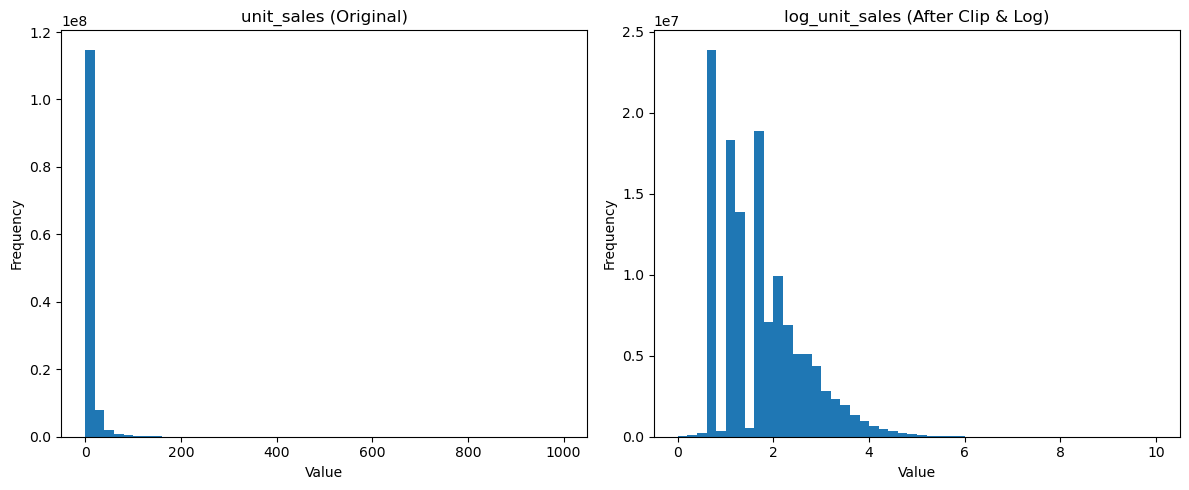

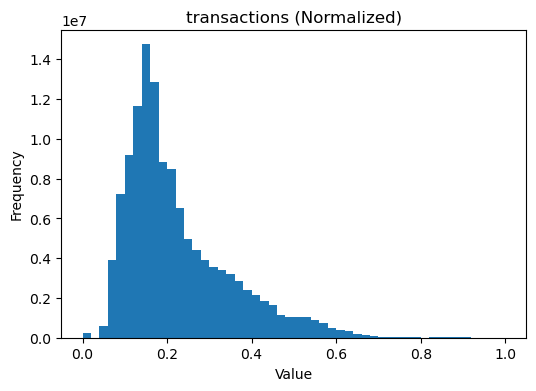

In [30]:
# --- Check values before preprocessing ---
print("=== Before Preprocessing ===")
from sklearn.preprocessing import MinMaxScaler

# 1. unit_sales
print("\nunit_sales:")
print(data["unit_sales"].describe())
print(f"NaN count: {data['unit_sales'].isna().sum()}")
print(f"Inf count: {np.isinf(data['unit_sales']).sum()}")

# 2. transactions
print("\ntransactions:")
print(data["transactions"].describe())
print(f"NaN count: {data['transactions'].isna().sum()}")
print(f"Inf count: {np.isinf(data['transactions']).sum()}")

# 3. Categoricals (avoid min/max for unordered categoricals)
categorical_cols = ["store_nbr", "item_nbr", "is_onpromotion", "is_holiday"]
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"Unique values: {data[col].nunique()}")
    print(f"NaN count: {data[col].isna().sum()}")
    print(f"Sample values: {data[col].unique()[:5]}")
    print(f"Type: {data[col].dtype}")
    print(f"Is Categorical? {pd.api.types.is_categorical_dtype(data[col])}")

# --- Apply preprocessing and check again ---
print("\n=== After Preprocessing ===")

# Preprocess data
data["log_unit_sales"] = np.clip(np.log1p(data["unit_sales"]), 0, 10)  # Clip outliers
scaler = MinMaxScaler()
data["transactions"] = scaler.fit_transform(data[["transactions"]])  # Normalize

# 1. log_unit_sales
print("\nlog_unit_sales:")
print(data["log_unit_sales"].describe())
print(f"NaN count: {data['log_unit_sales'].isna().sum()}")
print(f"Inf count: {np.isinf(data['log_unit_sales']).sum()}")

# 2. transactions (after normalization)
print("\ntransactions (normalized):")
print(data["transactions"].describe())
print(f"NaN count: {data['transactions'].isna().sum()}")
print(f"Inf count: {np.isinf(data['transactions']).sum()}")

# --- Visualize distributions ---
plt.figure(figsize=(12, 5))

# unit_sales (original)
plt.subplot(1, 2, 1)
plt.hist(data["unit_sales"], bins=50, range=(0, 1000))  # Limit range to see detail
plt.title("unit_sales (Original)")
plt.xlabel("Value")
plt.ylabel("Frequency")

# log_unit_sales (after preprocessing)
plt.subplot(1, 2, 2)
plt.hist(data["log_unit_sales"], bins=50)
plt.title("log_unit_sales (After Clip & Log)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# transactions (after normalization)
plt.figure(figsize=(6, 4))
plt.hist(data["transactions"], bins=50)
plt.title("transactions (Normalized)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [31]:
# # Preprocess data

data["log_unit_sales"] = np.clip(np.log1p(data["unit_sales"]), 0, 6)  # Clip outliers
scaler = MinMaxScaler()
data["transactions"] = scaler.fit_transform(data[["transactions"]])  # Normalize

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data["transactions"] = scaler.fit_transform(data[["transactions"]])
# Optionally normalize other reals
data[["day", "month", "weekday", "year"]] = scaler.fit_transform(data[["day", "month", "weekday", "year"]])

In [33]:
#Clip extreme values
data["log_unit_sales"] = data["log_unit_sales"].clip(lower=-10, upper=10)
data["transactions"] = data["transactions"].clip(lower=0, upper=1e6)
print("Log unit sales stats:", data["log_unit_sales"].describe())
print("Transactions stats:", data["transactions"].describe())

Log unit sales stats: count    1.263079e+08
mean     1.751354e+00
std      1.152293e+00
min      9.995003e-04
25%      1.098612e+00
50%      1.609438e+00
75%      2.302585e+00
max      6.000000e+00
Name: log_unit_sales, dtype: float64
Transactions stats: count    1.263079e+08
mean     2.249962e-01
std      1.248971e-01
min      0.000000e+00
25%      1.381744e-01
50%      1.855485e-01
75%      2.856801e-01
max      1.000000e+00
Name: transactions, dtype: float64


In [34]:
if 1==1:
    data.to_parquet('even_further_processed_sales_data_optimized_dtypes.parquet', engine='pyarrow')
    print("File saved as 'even_further_processed_sales_data_optimized_dtypes.parquet' using pyarrow.")

File saved as 'even_further_processed_sales_data_optimized_dtypes.parquet' using pyarrow.


In [35]:
print(data.isna().sum())  # Check for missing values
print(np.isinf(data["log_unit_sales"]).sum())  # Should be 0
print(data.describe())  # Look for extreme outliers

id                0
date              0
store_nbr         0
item_nbr          0
unit_sales        0
is_onpromotion    0
is_holiday        0
transactions      0
day               0
month             0
weekday           0
year              0
log_unit_sales    0
time_idx          0
dtype: int64
0


KeyboardInterrupt: 

In [ ]:
# Total rows after cleaning
total_rows_after = len(data)
print(f"Rows after cleaning: {total_rows_after}")
print(f"Rows removed: {total_rows_before - total_rows_after} ({(total_rows_before - total_rows_after) / total_rows_before * 100:.4f}%)")

In [ ]:
series_counts = data.groupby(["store_nbr", "item_nbr"]).size()

# Total number of series
num_series = series_counts.count()
print(f"Total number of time series: {num_series}")

# Optional: Summary statistics about series lengths
print("\nSeries length statistics:")
print(series_counts.describe())

# Optional: View the first few series and their lengths
print("\nFirst 5 series and their lengths:")
print(series_counts.head())



In [ ]:
if 1==1:
    total_series = data.groupby(["store_nbr", "item_nbr"]).ngroups
    print(f"Total series in full data: {total_series}")
    print(f"Series excluded in validation: 9545")
    print(f"Percentage excluded: {(9545 / total_series) * 100:.2f}%")
    

In [ ]:
if 1==1:
    series_lengths = data.groupby(["store_nbr", "item_nbr"]).size()
    print("Series length statistics in full data:")
    print(series_lengths.describe())
    print(f"Number of series shorter than {training.min_encoder_length + 1}:")
    print((series_lengths < (training.min_encoder_length + 1)).sum())
    

In [ ]:
if 1==1:
    future_data = data[data["time_idx"] > training_cutoff]
    future_series_lengths = future_data.groupby(["store_nbr", "item_nbr"]).size()
    print("Series length statistics beyond training_cutoff:")
    print(future_series_lengths.describe())
    print(f"Number of series with no future data: {(future_series_lengths == 0).sum()}")

In [ ]:
if 1==1:
    num_series_in_validation = len(validation.group_ids)
    print(f"Series retained in validation: {num_series_in_validation}")
    print(f"Series excluded: {total_series - num_series_in_validation}")

In [ ]:
if 1==1:
    total_series_ngroups = data.groupby(["store_nbr", "item_nbr"]).ngroups
    total_series_size = data.groupby(["store_nbr", "item_nbr"]).size().count()
    print(f"Total series (ngroups): {total_series_ngroups}")
    print(f"Total series (size count): {total_series_size}")

In [ ]:
if 1==1:
    print(f"Min time_idx: {data['time_idx'].min()}")
    print(f"Max time_idx: {data['time_idx'].max()}")
    print(f"Training cutoff: {training_cutoff}")
    print(f"Future time steps available: {data['time_idx'].max() - training_cutoff}")

In [ ]:
if 1==1:
    print(f"Prediction windows in validation (likely unique series): {len(validation)}")
    print(f"Series excluded: {total_series - len(validation)}")

In [ ]:
if 1==1:
    print(f"Rows in data: {len(data)}")
    print(f"Unique store_nbr, item_nbr pairs: {data.groupby(['store_nbr', 'item_nbr']).ngroups}")
    print(f"Duplicate rows: {data.duplicated().sum()}")


In [ ]:
if 1==1:
    retained_groups = set()
    
    for batch in val_dataloader:
        group_ids = batch[0]["groups"]  # Tensor of [store_nbr, item_nbr] pairs
        for group in group_ids:
            retained_groups.add(tuple(group.tolist()))  # Convert tensor to tuple for set
    
    # Get all group IDs from data
    all_groups = set(data.groupby(["store_nbr", "item_nbr"]).groups.keys())
    
    # Identify excluded groups
    excluded_groups = all_groups - retained_groups
    
    # Filter data for excluded series
    excluded_df = data[data.set_index(["store_nbr", "item_nbr"]).index.isin(excluded_groups)].reset_index()
    
    # Analyze excluded series
    print(f"Number of excluded series: {len(excluded_groups)}")
    print(f"Average log_unit_sales of excluded series: {excluded_df['log_unit_sales'].mean()}")
    print(f"Number of unique stores in excluded series: {excluded_df['store_nbr'].nunique()}")
    print(f"Number of unique items in excluded series: {excluded_df['item_nbr'].nunique()}")
    print(f"Percentage of total series excluded: {(len(excluded_groups) / total_series) * 100:.2f}%")





In [ ]:
if 1 == 1:
    training = TimeSeriesDataSet(
    data=data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="log_unit_sales",
    group_ids=["store_nbr", "item_nbr"],
    min_encoder_length=(max_encoder_length // 2) - 1,
    max_encoder_length=max_encoder_length,
    static_categoricals=["store_nbr", "item_nbr"],
    time_varying_known_categoricals=["is_onpromotion", "is_holiday"],
    time_varying_unknown_categoricals=[],
    time_varying_known_reals=["day", "month", "weekday", "year", "transactions"],
    time_varying_unknown_reals=["log_unit_sales"],
    target_normalizer=GroupNormalizer(groups=["store_nbr", "item_nbr"], transformation=None),  # Remove softplus
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)


In [ ]:
if 1 == -1:
    # Save dataset object
    torch.save(training, "training_dataset.pt")


In [ ]:
if 1==-1:
    # Load dataset object
    training = torch.load("training_dataset.pt",weights_only=False)


In [ ]:
# # Save the TimeSeriesDataSet object
# with open("training_dataset.pkl", "wb") as f:
#     pickle.dump(training, f)

# print("TimeSeriesDataSet saved successfully!")

In [ ]:
# # Load the saved TimeSeriesDataSet object
# with open("training_dataset.pkl", "rb") as f:
#     training = pickle.load(f)

# print("TimeSeriesDataSet loaded successfully!")

In [ ]:
#95% coverage for validation 

In [ ]:
if 1 == 1:
    # create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
    validation = TimeSeriesDataSet.from_dataset(
        training,
        data,
        predict=True,
        stop_randomization=True)

In [ ]:
if 1 == -1:
# Save dataset object
    torch.save(validation, "validation_dataset.pt")


In [ ]:
if 1 == -1:
    # Load dataset object
    validation = torch.load("validation_dataset.pt",weights_only=False)

In [ ]:
# create dataloaders for model
batch_size = 128  # setting it between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
print("Dataset categoricals:", training.categoricals)



In [ ]:
for batch in train_dataloader:
    x, y = batch
    print("Available keys in x:", x.keys())  # Debugging step
    break

In [ ]:
for batch in train_dataloader:
    x, y = batch
    print("Encoder Categorical Shape:", x["encoder_cat"].shape)
    print("Decoder Categorical Shape:", x["decoder_cat"].shape)
    break


In [ ]:
print("Available keys in hparams:", tft.hparams.keys())


In [ ]:
# Debug model embeddings
print("Model embedding names:", list(tft.input_embeddings.embeddings.keys()))
for name, emb in tft.input_embeddings.embeddings.items():
    print(f"Embedding for {name}: num_embeddings={emb.num_embeddings}, embedding_dim={emb.embedding_dim}")

In [ ]:
print("Available keys in hparams:", tft.hparams.keys())


In [ ]:
print("Defined categorical variables:", tft.hparams.time_varying_categoricals_encoder + tft.hparams.time_varying_categoricals_decoder)
print("Expected number of categorical features:", len(tft.hparams.time_varying_categoricals_encoder) + len(tft.hparams.time_varying_categoricals_decoder))


In [ ]:
print("Model embedding names:", list(tft.input_embeddings.embeddings.keys()))

In [ ]:
print("Static categorical variables:", tft.hparams.static_categoricals)


In [ ]:
unique_categoricals = list(set(tft.hparams.time_varying_categoricals_encoder + tft.hparams.time_varying_categoricals_decoder))
print("Unique categorical variables:", unique_categoricals)
print("Expected number of unique categorical features:", len(unique_categoricals))


In [ ]:
print("Static categorical variables:", tft.hparams.static_categoricals)


In [ ]:
# Combine static and time-varying categorical variables
all_categoricals = tft.hparams.static_categoricals + \
                   tft.hparams.time_varying_categoricals_encoder + \
                   tft.hparams.time_varying_categoricals_decoder

# Remove duplicates
unique_categoricals = list(set(all_categoricals))

print("Corrected categorical variables:", unique_categoricals)
print("Expected number of categorical features:", len(unique_categoricals))


In [ ]:
print("Encoder Categorical Features Shape:", x["encoder_cat"].shape)
print("Decoder Categorical Features Shape:", x["decoder_cat"].shape)


In [ ]:
for name, emb_layer in tft.input_embeddings.items():
    print(f"Embedding for {name}: {emb_layer}")


In [ ]:
x_cat_sample = x["encoder_cat"]  
embedded_cat = {name: tft.input_embeddings[name](x_cat_sample[..., idx]) 
                for idx, name in enumerate(tft.hparams.x_categoricals)}

for name, emb in embedded_cat.items():
    print(f"Embedded shape for {name}: {emb.shape}")


In [ ]:
# # Set DataLoader with More Workers for Faster Loading
# batch_size = 1024
# num_workers = 7  # Adjust based on CPU cores (Higher = Faster)
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=num_workers,pin_memory=True)
# val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers,pin_memory=True)

In [ ]:
#Create baseline model

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to(device)
baseline_predictions = Baseline().predict(val_dataloader)
baseline_predictions = baseline_predictions.to(device)
mae=(actuals - baseline_predictions).abs().mean().item()
print(f"MAE loss for naive base model prediction on validation: {mae:.4f}")


In [ ]:
sm_loss = SMAPE().loss(actuals, baseline_predictions.to(device)).mean(axis = 1).median().item()
print(f"Median loss for naive prediction on validation: {sm_loss:.4f}")


In [ ]:
print(training.get_parameters())

In [ ]:
#Train the Temporal Fusion Transformer

In [ ]:
# Define TFT Model
if 1==-1:
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.03,
        hidden_size=16,
        attention_head_size=4,
        dropout=0.2,
        hidden_continuous_size=8,
        output_size=7,  # Outputs for quantile forecasting
        loss=QuantileLoss(),
        logging_metrics=[MAE(), RMSE()],
        optimizer="ranger",
        reduce_on_plateau_patience=1000,
    )


In [ ]:
if 1==1:
    tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0011,
    hidden_size=128,              # Tuned hidden size
    attention_head_size=3,        # Tuned attention head size
    dropout=0.48,                 # Tuned dropout value
    hidden_continuous_size=40,    # Tuned continuous hidden size (<= hidden_size)
    loss=MAE(),
    optimizer="ranger",
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")


In [ ]:
# Callbacks
class DebugCallback(Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        loss = outputs["loss"].item()
        if not np.isfinite(loss):
            print(f"Batch {batch_idx} - Loss: {loss}")
            print("Predictions:", outputs["y_pred"][:5])
            print("Targets:", batch[1]["decoder_target"][:5])
            raise ValueError("Non-finite loss detected")

class DebugBatchCallback(Callback):
    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        print(f"Batch {batch_idx} - x_cat shape: {x['encoder_cat'].shape}")
        print(f"x_cat values: {x['encoder_cat'][:5]}")

In [ ]:
if 1 == 1:
    # configure network and trainer
    pl.seed_everything(69)
    # Define Trainer without any automatic LR finder callbacks (so tuner can be used)
    trainer = Trainer(
        accelerator="cuda" if torch.cuda.is_available() else "cpu",
        devices=1,
        max_epochs=1,  # One epoch is enough for lr_find
        gradient_clip_val=0.45,
        accumulate_grad_batches=1,
        callbacks=[RichProgressBar(),DebugCallback,DebugBatchCallback],
        precision="bf16-mixed"
        )


In [ ]:
if 1==-1:
    for name, param in tft.named_parameters():
        print(name, param.requires_grad)    



In [ ]:
if 1 == -1:
    tft.train
    for batch in train_dataloader:
        # batch typically is a tuple, e.g., (x, (y, weight))
        x, (y, weight) = batch  
        # Now use x as your inputs
        outputs = tft(x)
        print(outputs)
        print("outputs.requires_grad:", outputs.requires_grad)
        break  # Only check for one batch



In [ ]:
# if 1==1:
    
#     # Suppose x is your input dictionary that you updated so that all floating point tensors require gradients:
#     for key, value in x.items():
#         if isinstance(value, torch.Tensor) and value.is_floating_point():
#             x[key] = value.requires_grad_()
    
#     # Pass the updated x to your TFT model to get outputs
#     outputs = tft(x)
    
#     # Extract predictions (assuming tft returns an object with attribute "prediction")
#     if hasattr(outputs, "prediction"):
#         preds = outputs.prediction  # shape: (batch_size, seq_len, num_quantiles)
#     else:
#         preds = outputs  # if tft returns a tensor directly
    
#     # Determine the batch size and sequence length
#     batch_size, seq_len, num_quantiles = preds.shape
    
#     # Create dummy target tensor with shape (batch_size, seq_len)
#     # (For instance, here we set all target values to 1.0; replace this with your actual target values when available)
#     dummy_targets = torch.ones(batch_size, seq_len, device=preds.device)
    
#     # Instantiate QuantileLoss with your chosen quantiles
#     loss_fn = QuantileLoss(quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    
#     # Compute the loss; QuantileLoss expects predictions of shape (batch, seq_len, n_quantiles)
#     # and targets of shape (batch, seq_len)
#     loss = loss_fn(preds, dummy_targets)
#     print("Loss:", loss.item())
    
#     # Perform backward pass
#     loss.backward()


In [ ]:
# if 1 == -1:
#     def quantile_loss(y_pred, y_true, quantiles=[0.1, 0.5, 0.9]):
#         losses = []
#     # Assuming y_pred has shape (batch_size, num_quantiles) and y_true has shape (batch_size,)
#         for i, q in enumerate(quantiles):
#             errors = y_true - y_pred[:, i]
#         # The loss penalizes underestimates and overestimates differently based on q
#             losses.append(torch.max((q - 1) * errors, q * errors).mean())
#         return sum(losses)

#     # Use the function directly as your loss_fn
#     loss_fn = quantile_loss

#     for key, value in x.items():
#         if isinstance(value, torch.Tensor) and value.is_floating_point():
#             x[key] = value.requires_grad_()
#     # Forward pass: obtain model outputs
#     outputs = tft(x)

#     # Compute the loss using your function
#     loss = loss_fn(outputs, targets)
#     print("Loss:", loss.item())

#     # Backward pass: compute gradients
#     loss.backward()

#     # Update the model parameters (assuming you have an optimizer set up)
#     optimizer.step()
#     optimizer.zero_grad()



In [ ]:
if 1 == -1:
    # find optimal learning rate
    from lightning.pytorch.tuner import Tuner

    res = Tuner(trainer).lr_find(
        model=tft,
        train_dataloaders=train_dataloader,  # ensure train_dataloader is defined
        val_dataloaders=val_dataloader,        # ensure val_dataloader is defined
        min_lr=1e-3,
        max_lr=0.1,
        num_training=10,  # number of batches to run for lr_find
        mode="exponential"
    )

In [ ]:
# # Print and plot the suggested learning rate.
# suggested_lr = lr_finder.suggestion()
# print(f"Suggested learning rate: {suggested_lr}")
# fig = lr_finder.plot(show=True, suggest=True)
# fig.show()
# # Update the model's learning rate with the suggestion:
# tft.hparams.learning_rate = suggested_lr


In [ ]:
# # --- Wrap the model in a simple LightningModule wrapper ---
# class TFTLightningWrapper(pl.LightningModule):
#     def __init__(self, model):
#         super().__init__()
#         self.tft = model
#         self.loss_fn = self.tft.loss  # Use the loss defined in TFT

#     def forward(self, batch):
#         # TFT expects a dictionary input from the DataLoader.
#         return self.tft(batch)

#     def training_step(self, batch, batch_idx):
#         x, (y, weight) = batch  # Unpack batch as (x, (y, weight))
#         y_hat = self(x)
#         loss = self.loss_fn(y_hat, y)
#         self.log("train_loss", loss)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
# # # Wrap your TFT model
# wrapped_tft = TFTLightningWrapper(tft)

In [ ]:
# tft.train()
# # wrapped_tft.tft()

In [ ]:
# --- Define Trainer (using Lightning 2.5.1 syntax) ---
# Define Trainer
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=1,  # For tuning purposes
    precision="bf16-mixed"
)


In [ ]:
#for debugging 
# for name, param in tft.named_parameters():
#     print(name, param.requires_grad)

In [ ]:
# def configure_optimizers(self):
#     optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
#     return optimizer

In [ ]:
print(tft)

In [ ]:
print(type(tft))


In [ ]:
print(dir(tft))

In [ ]:
#for debugging 
# inputs, targets = next(iter(train_dataloader))  # Assuming you have a DataLoader


In [ ]:
#for debugging 
# tft.train()  # ensure training mode
# # optimizer.zero_grad()
# # optimizer.step()
# print(hasattr(tft, "loss"))
# print(tft.loss)

In [ ]:
#for debugging 
# outputs = tft(inputs)
# loss = loss_fn(outputs, targets)
# print(loss.requires_grad)  # Should be True
# loss.backward()

In [ ]:
#for debugging 
#def quantile_loss(y_pred, y_true, quantiles=[0.1, 0.5, 0.9]):
#     losses = []
#     for i, q in enumerate(quantiles):
#         errors = y_true - y_pred[..., i]  # Ensure correct indexing
#         losses.append(torch.max(q * errors, (q - 1) * errors).mean())
#     return sum(losses)

# loss_fn = quantile_loss
# loss = loss_fn(outputs[0], targets)  # Use outputs[0] if it's the main tensor
# loss.backward()

In [ ]:
#for debugging 
# outputs = tft(inputs)
# loss_fn = quantile_loss
# loss = loss_fn(outputs, targets)
# print(loss.requires_grad)  # should be True
# loss.backward()


In [ ]:
# class TFTDataModule(LightningDataModule):
#     def __init__(self, train_dataloader, val_dataloader):
#         super().__init__()
#         self.train_dataloader_instance = train_dataloader
#         self.val_dataloader_instance = val_dataloader

#     def train_dataloader(self):
#         return self.train_dataloader_instance

#     def val_dataloader(self):
#         return self.val_dataloader_instance

In [ ]:
# class TFTModel(LightningModule):
#     def __init__(self, batch_size=32, learning_rate=1e-3):  # Default values
#         super().__init__()
#         self.save_hyperparameters()  # Saves batch_size & lr to hparams
#         self.batch_size = batch_size
#         self.learning_rate = learning_rate
        
#         # Define your model layers here

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
print(trainer.callbacks)

In [ ]:
# trainer.callbacks = [cb for cb in trainer.callbacks if not isinstance(cb, BatchSizeFinder)]

In [ ]:
# tft.hparams.batch_size = 32  # Set initial batch size

In [ ]:
# tuner = Tuner(trainer)

# # Wrap dataloaders inside the LightningDataModule
# data_module = TFTDataModule(train_dataloader, val_dataloader)

# # Find optimal batch size
# optimal_batch_size = tuner.scale_batch_size(
#     model=tft,
#     datamodule=data_module,  # Use LightningDataModule
#     mode="power"
# )
# print(f"Optimal batch size: {optimal_batch_size}")


In [ ]:
# # configure network and trainer
# pl.seed_everything(69)
# trainer = pl.Trainer(
#     accelerator="gpu",  # Specify that you're using GPU
#     devices=1,          # Use one GPU
#     gradient_clip_val=0.1,
#     max_epochs=20,
# )

In [ ]:
# # Create a Tuner instance with the trainer
# tuner = Tuner(trainer)

In [ ]:
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# # --- Learning Rate Finder ---
# lr_finder = tuner.lr_find(
#     model=tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     min_lr=1e-8,
#     max_lr=1,
#     num_training=100,   # Number of batches to test
#     mode="exponential", # You can also try "linear"
#     early_stop_threshold=4.0,  # Stop early if loss gets too high
# )

# # Print suggested learning rate and plot the lr finder result
# print(f"Suggested learning rate: {lr_finder.suggestion()}")
# fig = lr_finder.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# # --- Batch Size Scaling ---
# optimal_batch_size = tuner.scale_batch_size(
#     model=tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     method="binsearch",   # Or "power" for exponential growth
#     steps_per_trial=3,     # Number of steps to test each batch size
#     init_val=2,            # Starting batch size to test
#     max_trials=25,         # Maximum number of batch size increases
#     batch_arg_name="batch_size",  # The hyperparameter name to update
# )

# print("Optimal batch size:", optimal_batch_size)

In [ ]:
# Set Up Trainer with GPU Acceleration
# pl.seed_everything(69)
# trainer = Trainer(
#     max_epochs=50,  # Can increase if needed
#     gradient_clip_val=0.1,  # Helps prevent exploding gradients
#     callbacks=[checkpoint_callback,earlystopping_callback],
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     devices=1 if torch.cuda.is_available() else None,  # Use GPU if available
#     precision="bf16-mixed",
#     profiler="simple",
#     log_every_n_steps=50  # Log less frequently
# )

In [ ]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [ ]:
#Find optimal learning rate

In [ ]:
# res = trainer.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )
# print(f"Suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()


In [ ]:
#Train model

In [ ]:
#callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",  # Directory to save models
    filename="tft_epoch_{epoch:02d}",  # Naming format
    save_top_k=-1,  # Save all epochs
    every_n_epochs=1,  # Save after every epoch
)
lr_logger = LearningRateMonitor()  # log the learning rate
earlystopping_callback=EarlyStopping(
    monitor="val_loss",
     min_delta=1e-4,
    patience=10,verbose=False, mode="min")
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


In [ ]:
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
